# DSC 540 - Milestone 5

## Import Data Sets

In [3]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [4]:
# Create and connect to SQL database
conn = sqlite3.connect('milestone.db')

In [5]:
# Import data sets
housing = pd.read_csv('FINAL_ZillowCSV.csv')
wikicensus = pd.read_csv('FINAL_WikiCityCensusHTML.csv')
cityinfo = pd.read_csv('FINAL_CitiesInfoAPI.csv')

## Load Data Sets to Database and JOIN them Using SQL

In [ ]:
# Load data sets as separate tables into database
housing.to_sql('housing', conn, if_exists='replace', index=False)
wikicensus.to_sql('wikicensus', conn, if_exists='replace', index=False)
cityinfo.to_sql('cityinfo', conn, if_exists='replace', index=False)

In [8]:
# Perform LEFT JOIN query to create a new table
query = """
CREATE TABLE IF NOT EXISTS merged_data AS
SELECT 
    housing.*,
    wikicensus.*, 
    cityinfo.*
FROM 
    housing
LEFT JOIN 
    wikicensus ON housing.RegionName = wikicensus.City
LEFT JOIN 
    cityinfo ON housing.RegionName = cityinfo.RegionName2;
"""

# Execute query
conn.execute(query)
conn.commit()

In [9]:
# Convert merged table into pandas dataframe
milestonedf = pd.read_sql('SELECT * FROM merged_data', conn)

# Close the connection
conn.close()

In [10]:
# Change name of columns that have a numeric value at the beginning
# to avoid confusing them with columns that have dates as their name
milestonedf.rename(columns={'2023estimate': 'estimate2023'}, inplace=True)
milestonedf.rename(columns={'2020census': 'census2020'}, inplace=True)
milestonedf.rename(columns={'2020 land areami2': 'landareami2_2020'}, inplace=True)
milestonedf.rename(columns={'2020 density/ mi2': 'density/mi2_2020'}, inplace=True)

In [11]:
# Print merged database
milestonedf

,RegionID,SizeRank,RegionName,State,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,...,km2,density/mi2_2020,/ km2,Location,RegionName2,Lat,Lon,Population,State:1,IsCapital?
0,6181,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"$243,953","$245,261","$246,618","$249,160",...,778.3,"29,298","11,312",40.66°N 73.94°W,New York,40.6943,-73.9249,18713220.0,New York,0.0
1,12447,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"$228,465","$228,821","$229,816","$231,814",...,"1,216.00","8,304","3,206",34.02°N 118.41°W,Los Angeles,34.1139,-118.4070,12750807.0,California,0.0
2,39051,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,"$103,177","$103,147","$102,999","$102,953",...,"1,658.60","3,599","1,390",29.79°N 95.39°W,Houston,29.7863,-95.3889,5464251.0,Texas,0.0
3,17426,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,"$129,925","$129,917","$130,185","$130,930",...,589.7,"12,061","4,657",41.84°N 87.68°W,Chicago,41.8373,-87.6862,8604203.0,Illinois,0.0
4,6915,4,San Antonio,TX,"San Antonio-New Braunfels, TX",Bexar County,"$98,470","$98,563","$98,635","$98,766",...,"1,291.90","2,876","1,110",29.46°N 98.52°W,San Antonio,29.4658,-98.5253,2049293.0,Texas,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,7797,1011,Waxahachie,TX,"Dallas-Fort Worth-Arlington, TX",Ellis County,None,None,None,None,...,None,None,None,None,None,NaN,NaN,NaN,None,NaN
1042,39899,1012,Mount Prospect,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,"$222,041","$221,977","$222,397","$223,439",...,None,None,None,None,None,NaN,NaN,NaN,None,NaN
1043,25550,1013,Lenexa,KS,"Kansas City, MO-KS",Johnson County,None,None,None,None,...,None,None,None,None,None,NaN,NaN,NaN,None,NaN
1044,47252,1014,Punta Gorda,FL,"Punta Gorda, FL",Charlotte County,"$121,216","$121,609","$121,954","$122,675",...,None,None,None,None,None,NaN,NaN,NaN,None,NaN


## Create Five Visualizations

In [13]:
# Identify the columns to melt between 2000 and 2025
date_columns = [col for col in milestonedf.columns if col[:4].isdigit() \
                and '2000' <= col[:4] <= '2025']

# Melt the DataFrame to ease the visualization process
melteddf = milestonedf.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'State', 'Metro',
             'CountyName', 'Population', 'estimate2023', 'census2020'],
    value_vars=date_columns,
    var_name='Date',
    value_name='House_Value')

In [14]:
# Ensure that the Date column is in datetime format
melteddf['Date'] = pd.to_datetime(melteddf['Date'])

# Remove dollar signs and commas in column 'House_Value'
# Convert Values to float
melteddf['House_Value'] = melteddf['House_Value'].\
                        replace({'\$': '', ',': ''}, regex=True).astype(float)

# Replace na values and convert to integers in 'House_Value'
melteddf['House_Value'] = melteddf['House_Value'].fillna(0).astype(int)

In [15]:
# Print melted data frame
melteddf

,RegionID,SizeRank,RegionName,State,Metro,CountyName,Population,estimate2023,census2020,Date,House_Value
0,6181,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,18713220.0,"8,258,035","8,804,190",2000-01-31,243953
1,12447,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,12750807.0,"3,820,914","3,898,747",2000-01-31,228465
2,39051,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,5464251.0,"2,314,157","2,304,580",2000-01-31,103177
3,17426,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,8604203.0,"2,664,452","2,746,388",2000-01-31,129925
4,6915,4,San Antonio,TX,"San Antonio-New Braunfels, TX",Bexar County,2049293.0,"1,495,295","1,434,625",2000-01-31,98470
...,...,...,...,...,...,...,...,...,...,...,...
309611,7797,1011,Waxahachie,TX,"Dallas-Fort Worth-Arlington, TX",Ellis County,NaN,None,None,2024-08-31,359455
309612,39899,1012,Mount Prospect,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,NaN,None,None,2024-08-31,429714
309613,25550,1013,Lenexa,KS,"Kansas City, MO-KS",Johnson County,NaN,None,None,2024-08-31,435162
309614,47252,1014,Punta Gorda,FL,"Punta Gorda, FL",Charlotte County,NaN,None,None,2024-08-31,419564


### Visualization #1 - Top 5 Cities by Population

In [17]:
# Create formatter to show axis in millions
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M')

In [18]:
# Filter data frame to include the home values of
# top 5 cities by population on 2024-08-31
vis1 = melteddf[
    (melteddf['SizeRank'].between(0, 4)) & 
    (melteddf['Date'] == '2024-08-31')].\
sort_values(by='Population', ascending=False)

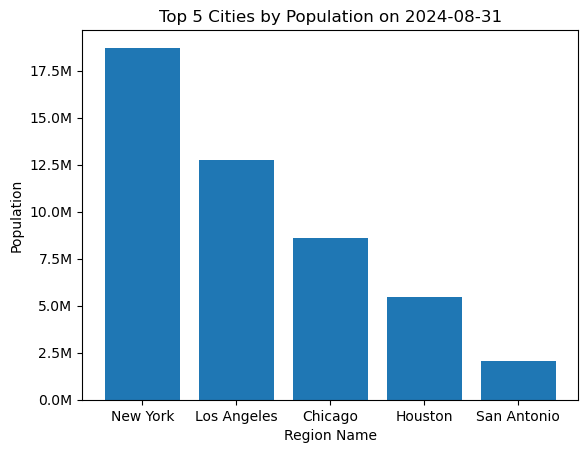

In [19]:
# Plot bar chart
plt.bar(vis1['RegionName'], vis1['Population'])

# Create labels
plt.xlabel('Region Name')
plt.ylabel('Population')
plt.title('Top 5 Cities by Population on 2024-08-31')

# Apply formatter on y-axis
plt.gca().yaxis.set_major_formatter(formatter)

# Show chart
plt.show()

### Visualization #2 - House Values of Top 10 Cities by Population on 2024-08-31 

In [21]:
# Filter data base to get top 10 cities by population and
# house values on 2024-08-31
vis2 = melteddf[
    (melteddf['SizeRank'].between(0, 9)) & 
    (melteddf['Date'] == '2024-08-31')].\
sort_values(by='Population', ascending=False)

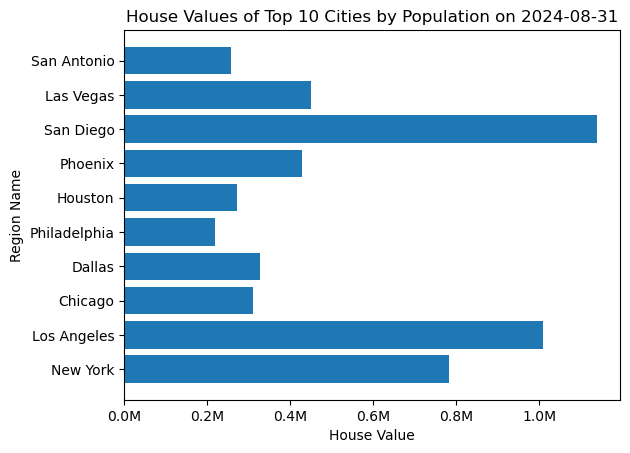

In [22]:
# Plot horizontal bar chart
plt.barh(vis2['RegionName'], vis2['House_Value'])

# Create labels
plt.xlabel('House Value')
plt.ylabel('Region Name')
plt.title('House Values of Top 10 Cities by Population on 2024-08-31')

# Apply formatter on x-axis
plt.gca().xaxis.set_major_formatter(formatter)

# Show chart
plt.show()

### Visualization #3 - Average Home Values Across 1,000 most Populated US Cities (2020-2024) 

In [24]:
# Group by year and calculate the average house value
vis3 = melteddf.groupby(melteddf['Date'].dt.year)['House_Value'].mean()

In [25]:
# Create formatter to show axis thousands separated by a comma
formatter_thousands = FuncFormatter(lambda x, _: f'{int(x):,}')

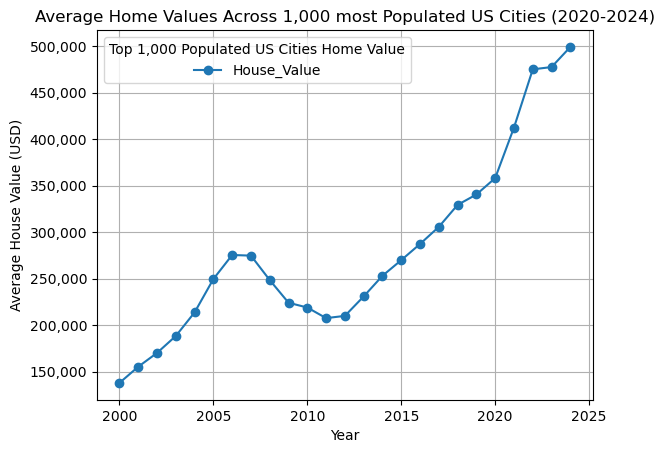

In [26]:
# Plot line chart
vis3.plot(kind='line', marker='o')

# Creat labels
plt.xlabel('Year')
plt.ylabel('Average House Value (USD)')
plt.title('Average Home Values Across 1,000 most Populated US Cities (2020-2024)')

# Add legend and grid
plt.legend(title='Top 1,000 Populated US Cities Home Value', loc='best')
plt.grid(True)

# Apply formatter to y-axis
plt.gca().yaxis.set_major_formatter(formatter_thousands)

# Show chart
plt.show()

### Visualization #4 - Home Values Across Top 5 most Populated US Cities (2020-2024)  

In [ ]:
# Filter data set to obtain top cities by size rank
vis4 = melteddf.loc[melteddf['SizeRank'] < 5]

# Convert dates in the Date column to datetime and extract the year
vis4['Year'] = vis4['Date'].dt.year

# Group by Year and RegionName. Calculate mean of house values.
vis4 = vis4.groupby(['Year', 'RegionName'])['House_Value'].mean().reset_index()

# Pivot data. Make each column to represent a city
vis4 = vis4.pivot(index='Year', columns='RegionName', values='House_Value')

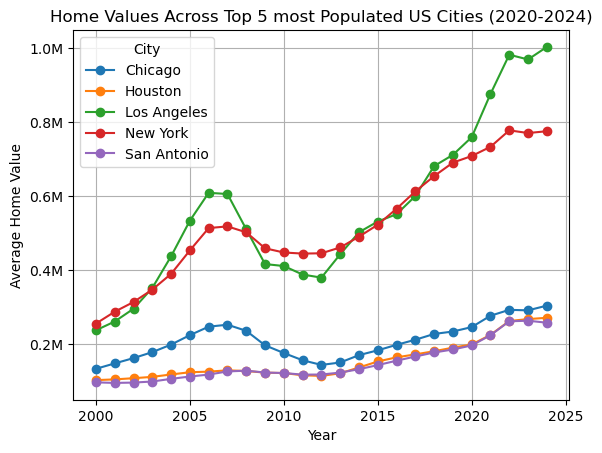

In [29]:
# Plot the line chart
vis4.plot(kind='line', marker='o')

# Add labels
plt.xlabel('Year')
plt.ylabel('Average Home Value')
plt.title('Home Values Across Top 5 most Populated US Cities (2020-2024)')

# Add legend and grid
plt.legend(title='City', loc='best')
plt.grid(True)

# Apply formatter on y axis
plt.gca().yaxis.set_major_formatter(formatter)

# Show chart
plt.show()

### Visualization #5 - Home Values by Size of Cities on 2024-08-31

In [31]:
# Filter data to get home values on 2024-08-31
vis5 = melteddf[melteddf['Date'] == '2024-08-31']

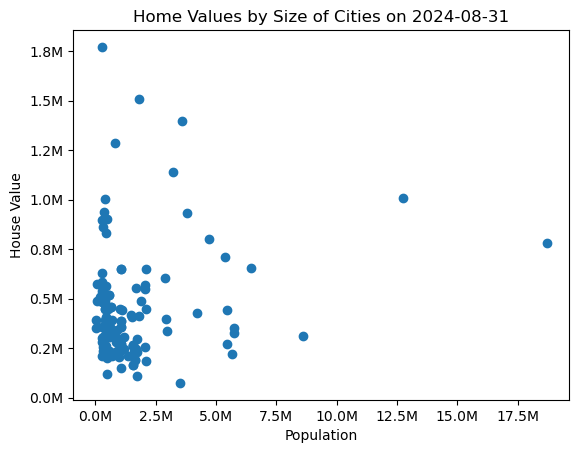

In [32]:
# Plot scatterplot
plt.scatter(vis5['Population'], vis5['House_Value'])

# Add labels
plt.xlabel('Population')
plt.ylabel('House Value')
plt.title('Home Values by Size of Cities on 2024-08-31')

# Apply formatter on y and x-axis
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Show chart
plt.show()

## Conclusion (340 words)

### Ethical Implications?

No ethical concerns were noted regarding using, analyzing, and manipulating the data obtained for this project. The data for this project was obtained from public sources that do not restrict its use for academic purposes. These public sources of information are managed by reputable companies and organizations that are credible and well-known for their data management capabilities. Most of the changes made to the original data were related to formatting. All format changes facilitated data analysis, visualization, and interpretation without changing the original values. 

### What did you do to complete your project?

Most of the time needed to complete this project was spent cleaning and preparing data. Finding websites with "interesting" or "fun" information was relatively easy. In comparison, it took time to find high-quality data relevant to this project's goal of comparing single-home values in the United States across different cities. Furthermore, it was necessary to analyze how various data sets could be joined together. It was assumed that historical data on stock prices could be compared with home values. After several hours of trying to fit the data into the historical housing market data, it was concluded that the historical stock pricing was irrelevant to achieve the objective of this project. Finding more data related to the cities region in the USA had greater impact on the final analysis. 

### What did you learn?

The two biggest lessons were that spending more time planning a project's purpose will save you time and that being capable and willing to adapt your objective after the analysis has started is essential to be an effective Data Scientist. I spent little time thinking about how my three data sets should work together. I learned that I could have saved a lot of time and frustration if I had spent more time finding the correct data sets rather than trying to fit data together that did not belong together. Hence, adapting and adjusting as you work to achieve your goals is essential for the completion of analysis that involves large data sets.